# import

In [81]:
# | code-fold : true
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import plotly.express as px
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

In [82]:
tf.config.experimental.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 잡답. keras와 tensorflow

* 2023 빅데분

```python
import tensorflow as tf # step 0, import

net = tf.keras.Sequential()  ## step 1. net 선언

layer = tf.keras.layers.Dense(1) ## step 2. add layer
net.add(layer)

net.compile(optimizer = "adam", loss = "mse")  ## step 3. net compile
net.fit(x_train, y_train, verbose=0,epochs=1000) ## step 4.  net fit
```
* 에이블 딥러닝

```python
from keras.models import Sequential # step 0. import
from keras.layers import Dense

model1 = Sequential( ) ## step 1. model 선언

model1.add(Dense(1, input_shape = (n_f,)))  ## step 2. layer 추가
model1.compile(optimizer = "adam", loss = "mse") ## step 3. 컴파일
model1.fit(x_train, y_train, epochs = 5, verbose=0) ## step 4. fit
```

`-` 그냥 요약하자면 둘이 표현법이 다른거지, 실제 공유하는 메모리 주소가 같다.

* 즉, 본인이 편한 표현법을 쓰면된당

In [83]:
import tensorflow as tf
from keras.models import Sequential
print(id(tf.keras.Sequential), id(Sequential))
print(id(tf.keras.layers.Dense), id(Dense))

96801139568096 96801139568096
96801138256176 96801138256176


***

#  다중 분류 1. 연습

## (1) 데이터 이해 및 정리

`-` 해당 데이터는 `iris` 붓꽃데이터이다.

In [84]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/iris.csv"
data = pd.read_csv(path)
data.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


`-` target변수를 정수 인코딩

In [85]:
data['Species'] = data['Species'].map({'setosa':0, 'versicolor':1, 'virginica':2})
data.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


`-` x, y분리

In [86]:
target = "Species"
x = data.drop(target, axis = 1)
y = data[target]

`-` 데이터셋 분할

In [87]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state = 20)

`-` scaling

In [88]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## (2) 모델링 1 : 은닉층 x

In [89]:
nf = x_train.shape[1]

In [90]:
model = Sequential()

model.add(Dense(3, input_shape = (nf,), activation = "softmax"))

## 정수 인코딩 - > loss : sparse_categorical_crossentropy
## 원핫 인코딩 - > loss : categorical_crossentropy
model.compile(optimizer = Adam(0.1), loss  = tf.keras.losses.sparse_categorical_crossentropy)

history = model.fit(x_train, y_train,
                                  validation_split = 0.2, epochs = 50, verbose = 0).history

`-` train, val loss 시각화

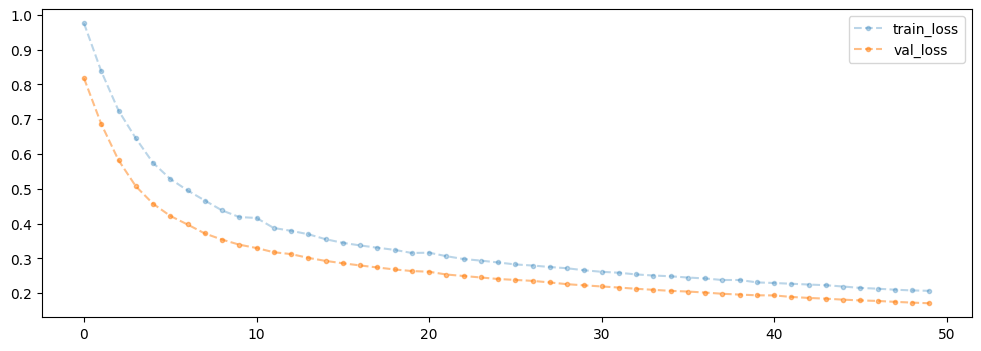

In [91]:
plt.figure(figsize = (12, 4))
plt.plot(history["loss"], "--.", label = "train_loss", alpha = 0.3)
plt.plot(history["val_loss"], "--.", label = "val_loss",alpha = 0.5)
plt.legend()
plt.show()

`-` 예측

In [92]:
pred =  model.predict(x_val)
pred[:5]

2/2 [==============================] - 0s 5ms/step


array([[9.79680717e-01, 2.02296004e-02, 8.96496858e-05],
       [1.11060282e-02, 7.97759116e-01, 1.91134900e-01],
       [1.30379135e-02, 7.17990279e-01, 2.68971771e-01],
       [4.22110228e-04, 3.48259479e-01, 6.51318491e-01],
       [3.11934222e-02, 8.82108092e-01, 8.66985321e-02]], dtype=float32)

In [93]:
y_pred = pred.argmax(axis = 1)

## (3) 예측결과 report

In [94]:
print(confusion_matrix(y_val, y_pred))
print("\n")
print(classification_report(y_val, y_pred))

[[13  0  0]
 [ 0 17  1]
 [ 0  4 10]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.81      0.94      0.87        18
           2       0.91      0.71      0.80        14

    accuracy                           0.89        45
   macro avg       0.91      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45



***

# 다중 분류 2. 은닉층 추가


| Layer (type) | Output Shape | Param # | 옵션 |
| ---- | ---- | ---- | ---- |
| dense (Dense) | (None, 8) | 40 | node, input_shape, activation = 'relu' |
| dense_1 (Dense) | (None, 3) | 27 | node, activation = 'softmax'  |

## (1) import `losses`

In [95]:
from keras import losses

## (2) 모델 설계

In [96]:
model = Sequential()
model.add(Dense(8, input_shape= (nf,), activation = "relu"))
model.add(Dense(3, activation = "softmax"))
model.compile(optimizer = Adam(0.01), loss = losses.sparse_categorical_crossentropy)

histoty = model.fit(x_train, y_train, epochs = 50,
                                validation_split = 0.2, verbose = 0).history

In [97]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 40        
                                                                 
 dense_13 (Dense)            (None, 3)                 27        
                                                                 
Total params: 67 (268.00 Byte)
Trainable params: 67 (268.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## (3) train, val loss 시각화

In [98]:
def loss_v(history) :
      plt.figure(figsize = (12, 4))
      plt.plot(history["loss"], "--.", label = "train_loss", alpha = 0.3)
      plt.plot(history["val_loss"], "--.", label = "val_loss",alpha = 0.5)
      plt.legend()
      plt.show()

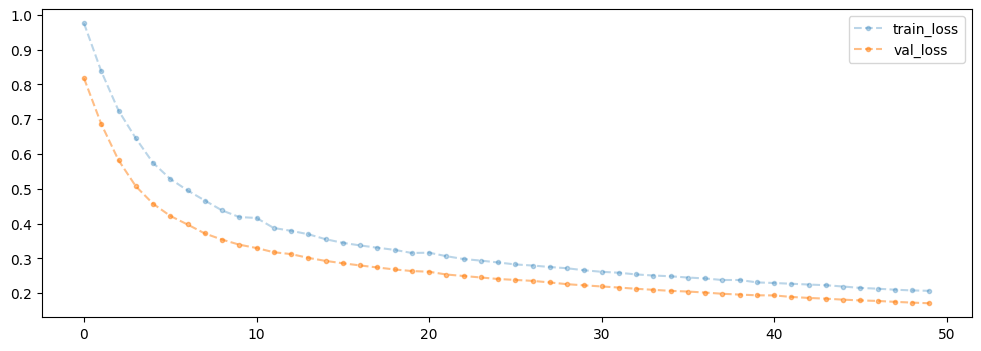

In [99]:
loss_v(history)

## (4) 예측

In [100]:
pred = model.predict(x_val).argmax(axis =1)

2/2 [==============================] - 0s 5ms/step


In [101]:
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[13  0  0]
 [ 0 18  0]
 [ 0  3 11]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.86      1.00      0.92        18
           2       1.00      0.79      0.88        14

    accuracy                           0.93        45
   macro avg       0.95      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



# 다중 분류 3. 은닉층 2개 추가

| Layer (type) | Output Shape | Param # | 옵션 |
| ---- | ---- | ---- | ---- |
| dense (Dense) | (None, 8) | 40 | node, input_shape, activation = 'relu' |
| dense_1 (Dense) | (None, 8) | 72 | node, activation = 'relu'  |
| dense_2 (Dense) | (None, 3) | 27 | node, activation = 'softmax'  |

## (1) 모델 설계

In [102]:
model = Sequential()
model.add(Dense(8, input_shape= (nf,), activation = "relu"))
model.add(Dense(8, activation = "relu"))
model.add(Dense(3, activation = "softmax"))
model.compile(optimizer = Adam(0.01), loss = losses.sparse_categorical_crossentropy)

histoty = model.fit(x_train, y_train, epochs = 50,
                                validation_split = 0.2, verbose = 0).history

In [103]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 8)                 40        
                                                                 
 dense_15 (Dense)            (None, 8)                 72        
                                                                 
 dense_16 (Dense)            (None, 3)                 27        
                                                                 
Total params: 139 (556.00 Byte)
Trainable params: 139 (556.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## (2) train, val loss 확인

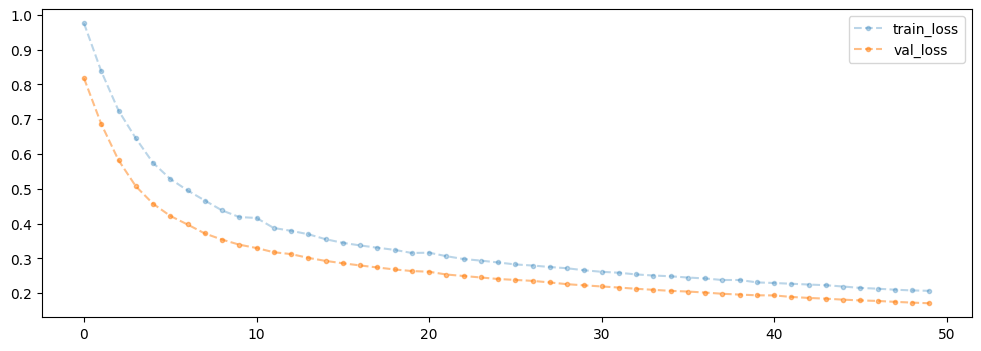

In [104]:
loss_v(history)

## (3) 예측

In [105]:
pred = model.predict(x_val).argmax(axis = 1)

print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

2/2 [==============================] - 0s 4ms/step
[[13  0  0]
 [ 0 18  0]
 [ 0  2 12]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.90      1.00      0.95        18
           2       1.00      0.86      0.92        14

    accuracy                           0.96        45
   macro avg       0.97      0.95      0.96        45
weighted avg       0.96      0.96      0.96        45



`-` 결과를 보니 은닉층 1개를 추가할 때와 비교했을 떄 성능 차이가 없음

* 모델을 충분히 복잡하게 하지 않아도 될 것 같다!

***

 # 다중 분류 4. 원핫 인코딩

`-` 이전까지는 `원핫 인코딩`이 아닌 각 타겟들의 고유 범주를 `정수 인코딩`으로 변환했음

* 이번엔 원핫 인코딩을 이용하여 모델을 fit하는 과정을 끄적끄적~~

## (1) import

In [106]:
from keras.utils import to_categorical

In [107]:
y_c = to_categorical(y.values, 3)

In [108]:
y_c[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## (2) 데이터 전처리

`-` 데이터셋 분할

In [109]:
x_train, x_val, y_train, y_val = train_test_split(x, y_c, test_size = .3, random_state = 2022)

`-` 스케일링

In [110]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## (3) 모델 설계

`-` 모델 설계

In [111]:
model = Sequential([Dense(3, input_shape = (nf,), activation = 'softmax')])

model.compile(optimizer=Adam(learning_rate=0.1), loss='categorical_crossentropy')

history = model.fit(x_train, y_train, epochs = 100,
                    validation_split=0.2,verbose=0).history

## (4) loss 시각화

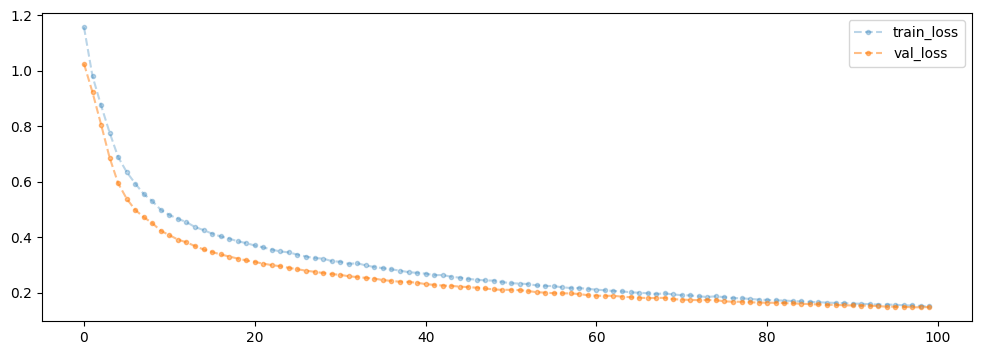

In [112]:
loss_v(history)

## (5) 예측

In [113]:
pred = model.predict(x_val).argmax(axis=1)
pred[:5]

2/2 [==============================] - 0s 5ms/step


array([2, 2, 0, 2, 0])

`-` y_val 도 원래대로 돌려놈 (decoding)

In [114]:
y_val_1 = y_val.argmax(axis=1)
y_val_1

array([2, 2, 0, 2, 0, 0, 1, 1, 0, 1, 1, 2, 1, 2, 2, 0, 1, 2, 2, 1, 0, 0,
       2, 0, 2, 2, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 2, 1, 1, 2,
       2])

`-` 결과 report 작성

In [115]:
print(confusion_matrix(y_val_1, pred))
print(classification_report(y_val_1, pred))

[[14  0  0]
 [ 0 14  1]
 [ 0  2 14]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.88      0.93      0.90        15
           2       0.93      0.88      0.90        16

    accuracy                           0.93        45
   macro avg       0.94      0.94      0.94        45
weighted avg       0.93      0.93      0.93        45



***

# 다중분류 5. 실습 (1)

## (1) 데이터 이해 및 정리

In [116]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/winequality-white.csv"
data = pd.read_csv(path)
data['quality'] = np.where(data['quality'] == 3, 4, np.where(data['quality'] == 9, 8, data['quality']))
data['quality'] = data['quality'] - 4
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,2
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,2
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,2
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2


In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


`-` x, y 분리

In [118]:
target = 'quality'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [122]:
y.value_counts()

2    2198
1    1457
3     880
0     183
4     180
Name: quality, dtype: int64

`-` 데이터셋 분할

In [120]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size= .3, random_state = 20)

`-` 스케일링

In [121]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## (2) 모델링 : 3개의 모델을 생성 후 비교

||output_shape|activation|
|:---:|:---:|:---:|
|model1|(8, 4, 5)|(relu, relu, softmax)|
|model2|(16, 8, 4, 5)|(relu, relu, relu, softmax)|
|model3|(32, 16, 8, 4, 5)|(relu, relu, relu, relu, softmax)|

### 1) 모델 설계

In [149]:
nf = x_train.shape[1]
nf

11

In [150]:
# model1 설계
model1 = Sequential()
model1.add(Dense(8, input_shape = (nf,), activation = "relu"))
model1.add(Dense(4, activation = "relu"))
model1.add(Dense(5, activation = "softmax"))
model1.compile(optimizer = Adam(0.01), loss = losses.sparse_categorical_crossentropy)

# model2 설계
model2 = Sequential()
model2.add(Dense(16, input_shape = (nf,), activation = "relu"))
model2.add(Dense(8, activation = "relu"))
model2.add(Dense(4, activation = "relu"))
model2.add(Dense(5, activation = "softmax"))
model2.compile(optimizer = Adam(0.01), loss = losses.sparse_categorical_crossentropy)

# model3 설계
model3 = Sequential()
model3.add(Dense(32, input_shape = (nf,), activation = "relu"))
model3.add(Dense(16, input_shape = (nf,), activation = "relu"))
model3.add(Dense(8, activation = "relu"))
model3.add(Dense(4, activation = "relu"))
model3.add(Dense(5, activation = "softmax"))
model3.compile(optimizer = Adam(0.01), loss = losses.sparse_categorical_crossentropy)

### 2) 모델 학습

In [151]:
for i in range(1, 4) :
       exec(f"""hisory{i}=model{i}.fit(x_train, y_train, epochs = 50,
                                                            verbose = 0, validation_split = 0.2).history""")

### 3) 모델별 train, val loss 시각화

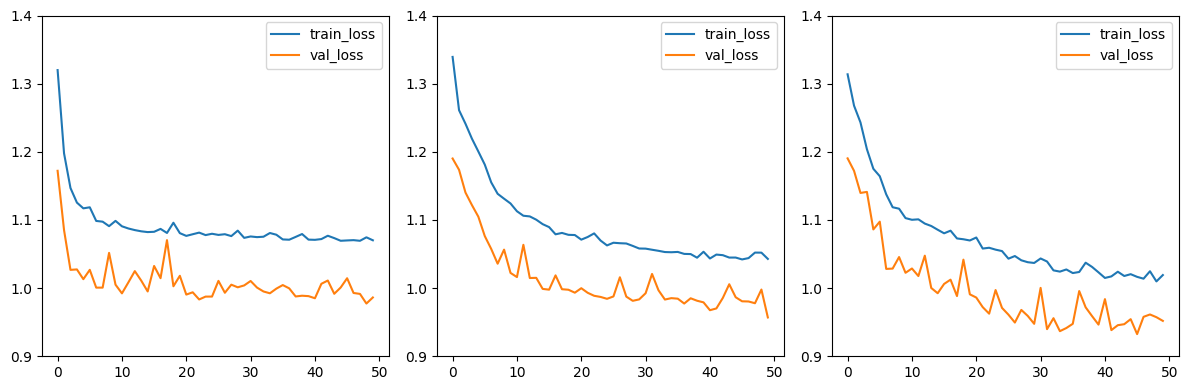

In [155]:
fig, axes = plt.subplots(1,3, figsize = (12 ,4))

for i in range(3) :
      exec(f"axes[{i}].plot(hisory{i+1}['loss'],label = 'train_loss')")
      exec(f"axes[{i}].plot(hisory{i+1}['val_loss'], label = 'val_loss')")
      axes[i].legend()
      axes[i].set_ylim(0.9,1.4)
fig.tight_layout()
fig.show()

`-` val_loss를 살펴본 결과 model3이 가장 적합한 모델로 판정됨

`-` 그런데...val_loss가 너무 들쑥날쑥하다....

* 학습률을 낮추고 에포크를 늘려보자.

In [176]:
model3 = Sequential()
model3.add(Dense(32, input_shape = (nf,), activation = "relu"))
model3.add(Dense(16, input_shape = (nf,), activation = "relu"))
model3.add(Dense(8, activation = "relu"))
model3.add(Dense(4, activation = "relu"))
model3.add(Dense(5, activation = "softmax"))
model3.compile(optimizer = Adam(0.001), loss = losses.sparse_categorical_crossentropy)

hisory_final =model3.fit(x_train, y_train, epochs = 100,
                                                            verbose = 0, validation_split = 0.2).history

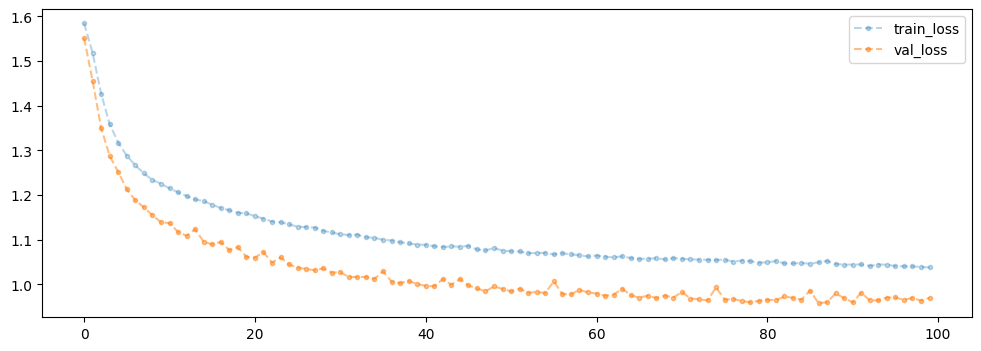

In [177]:
loss_v(hisory_final)

`-` 전보다 안정된 `loss`양상을 보인다

### 4) 선택된 모델의 예측 report 작성

In [178]:
pred = model3.predict(x_val).argmax(axis=1)

46/46 [==============================] - 0s 2ms/step


In [179]:
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred, zero_division = 0))

[[  0  43  18   0   0]
 [  0 233 198   7   0]
 [  0 114 479  67   0]
 [  0   6 157  87   0]
 [  0   0  30  31   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.59      0.53      0.56       438
           2       0.54      0.73      0.62       660
           3       0.45      0.35      0.39       250
           4       0.00      0.00      0.00        61

    accuracy                           0.54      1470
   macro avg       0.32      0.32      0.31      1470
weighted avg       0.50      0.54      0.51      1470



`-` 결과가 쓰레기다.

`-` 이유 : 현재 0과 4는 아예 못맞춤...학습 데이터의 불균형이 문제인 것 같다.

In [180]:
y_train.value_counts()

2    1538
1    1019
3     630
0     122
4     119
Name: quality, dtype: int64

In [181]:
y_val.value_counts()

2    660
1    438
3    250
4     61
0     61
Name: quality, dtype: int64

`-` 변수를 더 준비하면 모델 성능이 더 늘어날려나?

* 그런 문제가 아닌 것 같다..

# 다중분류 5. 실습 (2) MNIST

## (1) 데이터 이해 및 준비

In [183]:
from keras.datasets import mnist, fashion_mnist

In [184]:
# 케라스 데이터셋으로 부터 mnist 불러오기
(x_train, y_train), (x_val, y_val) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


`-` 이미지 한개당 `28 x 28`의 픽셀 차원을 가진다..

In [186]:
x_train.shape

(60000, 28, 28)

`-` 숫자가 `0`인것만 시각화

In [210]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

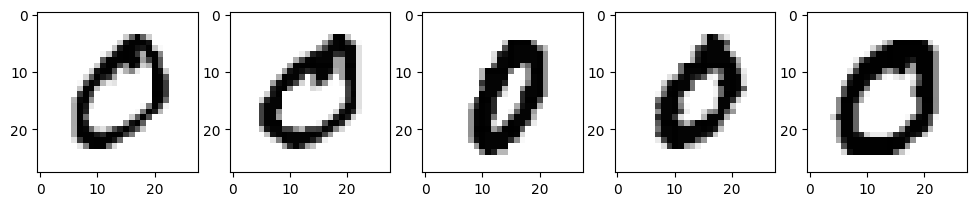

In [212]:
fig, axes = plt.subplots(1,5, figsize = (12,4))
for i in range(5) :
      im = axes[i].imshow(x_train[y_train ==0][i],cmap=plt.cm.binary)

`-` 데이터 `flatten` $\to$ 28 x 28 = 784

In [218]:
x_train = x_train.reshape(60000, -1)
x_val = x_val.reshape(10000, -1)

In [220]:
x_train.shape, x_val.shape

((60000, 784), (10000, 784))

`-` 이미지 데이터는 한 픽셀에서 `0~255` 의 숫자를 가진다.

* 즉, 스케일링 시 굳이 뭐 스케일러를 쓸 필요없이 255로 나누면 끝난다.

`-` 스케일링 수행

In [223]:
x_train = x_train / 255.
x_test = x_val / 255.

In [226]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [227]:
np.unique(y_val, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

## (2) 모델링

In [229]:
nf = x_train.shape[1]
nf

784

In [230]:
model = Sequential()
model.add(Dense(10, input_shape = (nf,), activation = "softmax"))
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [232]:
model.compile(optimizer = Adam(0.001), loss = losses.sparse_categorical_crossentropy)
h = model.fit(x_train, y_train, epochs = 20, validation_split = 0.2, verbose = 0).history

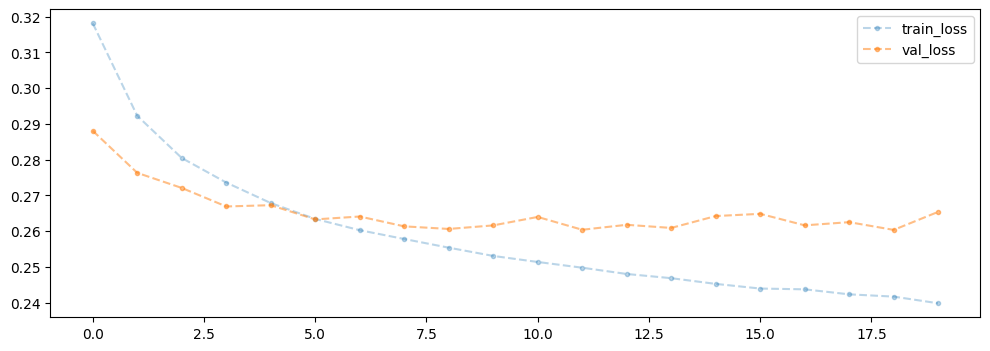

In [233]:
loss_v(h)

## (3) 예측

In [234]:
pred = model.predict(x_test).argmax(axis = 1)

313/313 [==============================] - 1s 2ms/step


In [235]:
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[ 954    0    2    2    0    7   12    2    1    0]
 [   0 1118    3    1    0    1    4    2    6    0]
 [   4   13  926   14    4    4   15    8   40    4]
 [   3    0   15  932    0   21    2   11   18    8]
 [   1    3   10    1  899    0   13    4    9   42]
 [   7    2    4   37    6  770   19    6   33    8]
 [   9    3    9    1    6    7  920    1    2    0]
 [   1    9   20    7    4    1    0  945    2   39]
 [   7   10    7   23    7   24   11    9  865   11]
 [  10    8    1   11   15    4    0   17    5  938]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.96      0.99      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.91      0.92      0.91      1010
           4       0.96      0.92      0.93       982
           5       0.92      0.86      0.89       892
           6       0.92      0.96      0.94       958
           7       0.94      0.92   

***

# 다중분류 6. 실습 (3) MNIST (2개 모델 비교)

## (1) Layer 정의

In [254]:
d1   = [Dense(20, input_shape = (nf,), activation = "relu"), Dense(10, activation = "softmax")]
d2   = [Dense(20, input_shape = (nf,), activation = "relu"),Dense(80, activation = "relu"), Dense(10, activation = "softmax")]

## (2) model 학습

In [255]:
for i in range(1,3) :
    exec(f"model{i} =  Sequential(d{i})")
    exec(f"model{i}.compile(optimizer = Adam(0.001),loss = losses.sparse_categorical_crossentropy)")
    exec(f"h{i}= model{i}.fit(x_train,y_train, validation_split = 0.2, verbose = 0, epochs = 20).history")

## (3) model 확인

In [256]:
model1.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 20)                15700     
                                                                 
 dense_76 (Dense)            (None, 10)                210       
                                                                 
Total params: 15910 (62.15 KB)
Trainable params: 15910 (62.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [257]:
model2.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 20)                15700     
                                                                 
 dense_78 (Dense)            (None, 80)                1680      
                                                                 
 dense_79 (Dense)            (None, 10)                810       
                                                                 
Total params: 18190 (71.05 KB)
Trainable params: 18190 (71.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## (4) train, val loss 비교

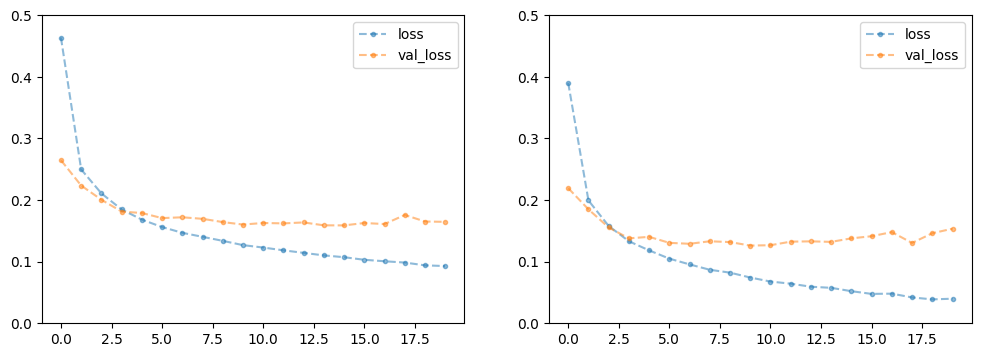

In [265]:
fig, axes = plt.subplots(1,2, figsize=(12, 4))

for i in range(2) :
        exec(f"axes[{i}].plot(h{i+1}['loss'], '--.', label = 'loss', alpha = 0.5)")
        exec(f'axes[{i}].plot(h{i+1}["val_loss"], "--.", label = "val_loss", alpha = 0.5)')
        exec(f'axes[{i}].legend()')
        exec(f'axes[{i}].set_ylim(0,0.5)')

## (5) 예측성능 확인

In [266]:
p1 = model1.predict(x_test).argmax(axis = 1)
p2 = model2.predict(x_test).argmax(axis = 1)

print(classification_report(y_val, p1))
print(classification_report(y_val, p2))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.94      0.96      1032
           3       0.94      0.96      0.95      1010
           4       0.96      0.95      0.95       982
           5       0.95      0.95      0.95       892
           6       0.96      0.97      0.97       958
           7       0.97      0.95      0.96      1028
           8       0.94      0.95      0.95       974
           9       0.95      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97